In [1]:
%load_ext kedro.extras.extensions.ipython

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [2]:
%reload_kedro

2022-08-25 15:04:21,246 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-mlflow-0.8.1
2022-08-25 15:04:21,294 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-08-25 15:04:21,853 - root - INFO - ** Kedro project GetInData ML Framework
2022-08-25 15:04:21,853 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-08-25 15:04:21,863 - root - INFO - Registered line magic `run_viz`
2022-08-25 15:04:21,864 - root - INFO - Registered line magic `reload_kedro_mlflow`


In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [5]:
[data for data in catalog.list() if not data.startswith('params:')]

['articles',
 'customers',
 'transactions',
 'customers_sample',
 'transactions_sample',
 'articles_sample',
 'input_images',
 'resized_images',
 'image_embeddings',
 'text_embeddings',
 'candidates',
 'train_transactions',
 'val_transactions',
 'train_candidates',
 'automated_articles_features',
 'automated_customers_features',
 'manual_article_features',
 'manual_customer_features',
 'manual_customer_prod_group_features',
 'jaccard_similarity_features',
 'image_cosine_similarity_features',
 'text_cosine_similarity_features',
 'candidates_similarity_features',
 'recommendations',
 'parameters']

In [6]:
recs = context.catalog.load('recommendations')

2022-08-25 15:04:39,208 - kedro.io.data_catalog - INFO - Loading data from `recommendations` (ParquetDataSet)...


DataSetError: Failed while loading data from data set ParquetDataSet(filepath=/Users/mmadej/Desktop/Projects/gid-ml-framework/data/07_model_output/recommendations.pq, load_args={'engine': pyarrow}, protocol=file, save_args={}).
[Errno 2] No such file or directory: '/Users/mmadej/Desktop/Projects/gid-ml-framework/data/07_model_output/recommendations.pq'

### loading data

In [6]:
candidates = context.catalog.load('candidates_similarity_features')

2022-08-25 13:17:18,238 - kedro.io.data_catalog - INFO - Loading data from `candidates_similarity_features` (ParquetDataSet)...


In [7]:
candidates.shape

(184074999, 6)

In [8]:
val_transactions = context.catalog.load('val_transactions')

2022-08-25 13:20:02,753 - kedro.io.data_catalog - INFO - Loading data from `val_transactions` (CSVDataSet)...


In [9]:
val_transactions = val_transactions[['customer_id', 'article_id']].assign(label=lambda x: 1)

In [10]:
val_transactions.shape

(240311, 3)

In [11]:
val_transactions = val_transactions.drop_duplicates()

In [12]:
val_transactions.shape

(213728, 3)

In [13]:
candidates.groupby(['customer_id'])['article_id'].nunique().describe(percentiles=
                                                                     [0.001, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99])

count   1371980.0000
mean        134.1674
std          24.8531
min         120.0000
0.1%        120.0000
10%         120.0000
20%         121.0000
50%         127.0000
80%         138.0000
90%         165.0000
99%         235.0000
max         770.0000
Name: article_id, dtype: float64

##### only 1 way needed

sample frac=1 is inefficient, but probably more correct

## maybe keep all positive examples??

candidates = candidates.merge(val_transactions, on=['customer_id', 'article_id'], how='left').fillna({'label': 0})

candidates['label'] = candidates['label'].astype(int)

positive_candidates = candidates.groupby(['customer_id'])['label'].max().reset_index()

positive_candidates.shape

positive_candidates = positive_candidates[positive_candidates.label>0]

positive_candidates.shape

candidates.shape

candidates = candidates[candidates.customer_id.isin(positive_candidates.customer_id.to_list())]

candidates.shape

In [13]:
candidates = candidates.sample(frac=1, random_state=888).groupby(['customer_id']).head(10).reset_index(drop=True)

candidates = candidates.groupby(['customer_id']).sample(n=200, random_state=888).reset_index(drop=True)

In [14]:
candidates.shape

(13719800, 6)

In [15]:
val_transactions.shape

(213728, 3)

In [16]:
candidates = candidates.merge(val_transactions, on=['customer_id', 'article_id'], how='left').fillna({'label': 0})

In [17]:
candidates['label'] = candidates['label'].astype(int)

In [18]:
candidates.shape

(13719800, 7)

In [19]:
candidates.customer_id.nunique()

1371980

In [20]:
candidates.head()

,customer_id,article_id,strategy_name,articles_jaccard_similarity,image_cosine_similarity,text_cosine_similarity,label
0,3c7ae318f27e2457d45166db351c874b3d77f8ae3cec7f...,0896169002,global_articles,0.0000,0.0000,0.0000,0
1,584a2cf30e5cb9599325689d40f8dd82a5f1431c78eb9d...,0706016002,global_articles,0.0000,0.0000,0.0000,0
2,5e6083a51cd0fcc515db5fff30096431a30dac77d34242...,0898694002,global_articles,0.0000,0.0000,0.0000,0
3,251a455e496cffd99e2d22971627ec85768e81619e2c1b...,0573085028,global_articles,0.0000,0.0000,0.0000,0
4,1bc213ee255670e7b385ecef93d40d4c4d5e8982af1643...,0910601003,global_articles,0.0323,0.8796,0.5787,0


In [21]:
candidates.label.value_counts(normalize=True)

0   0.9998
1   0.0002
Name: label, dtype: float64

In [22]:
candidates.label.value_counts(normalize=False)

0    137175296
1        22704
Name: label, dtype: int64

In [14]:
137175296/22704

6041.899929527836

In [23]:
candidates.groupby(['customer_id'])['article_id'].nunique().describe()

count   1371980.0000
mean        100.0000
std           0.0000
min         100.0000
25%         100.0000
50%         100.0000
75%         100.0000
max         100.0000
Name: article_id, dtype: float64

### optimizing data

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
               # fucking pandas types
                'Int16', 'Int32', 'Int64', 'Float16', 'Float32', 'Float64'
               ]
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Starting usage memory: {start_mem:.2f}')

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).lower()[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np. float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # if col_type == 'object':
            # here
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
candidates = reduce_mem_usage(candidates)

Starting usage memory: 837.39
Mem. usage decreased to 588.79 Mb (29.7% reduction)


### regex

In [21]:
import re

In [22]:
count_pattern = '^[Cc][Oo][Uu][Nn][Tt]'

In [23]:
def fill_na_int(df, regex_pattern, fill_na_value):
    cols = [col for col in df.columns if re.match(regex_pattern, col)]
    df.loc[:, cols] = df.loc[:, cols].fillna(fill_na_value).astype(int)
    return df

### articles

In [26]:
automated_articles_features = context.catalog.load('automated_articles_features')

2022-08-24 11:12:48,427 - kedro.io.data_catalog - INFO - Loading data from `automated_articles_features` (ParquetDataSet)...


In [27]:
manual_article_features = context.catalog.load('manual_article_features')

2022-08-24 11:12:48,522 - kedro.io.data_catalog - INFO - Loading data from `manual_article_features` (ParquetDataSet)...


In [28]:
automated_articles_features = fill_na_int(automated_articles_features, count_pattern, 0)

In [29]:
automated_articles_features = reduce_mem_usage(automated_articles_features)

Starting usage memory: 19.73
Mem. usage decreased to 12.08 Mb (38.8% reduction)


In [30]:
manual_article_features = reduce_mem_usage(manual_article_features)

Starting usage memory: 0.75
Mem. usage decreased to  0.50 Mb (33.3% reduction)


In [31]:
candidates = candidates.merge(automated_articles_features, how='left', on='article_id')

In [32]:
candidates = candidates.merge(manual_article_features, how='left', on='article_id')

In [24]:
import gc

In [34]:
del automated_articles_features
gc.collect()

1766

In [35]:
del manual_article_features
gc.collect()

0

In [36]:
candidates.shape

(137198000, 27)

### customers

In [34]:
automated_customers_features = context.catalog.load('automated_customers_features')

2022-08-23 19:14:25,818 - kedro.io.data_catalog - INFO - Loading data from `automated_customers_features` (ParquetDataSet)...


In [37]:
manual_customer_features = context.catalog.load('manual_customer_features')

2022-08-24 11:15:01,103 - kedro.io.data_catalog - INFO - Loading data from `manual_customer_features` (ParquetDataSet)...


In [36]:
automated_customers_features = fill_na_int(automated_customers_features, count_pattern, 0)

In [38]:
manual_customer_features = fill_na_int(manual_customer_features, count_pattern, 0)

In [38]:
automated_customers_features = reduce_mem_usage(automated_customers_features)

Starting usage memory: 194.49
Mem. usage decreased to 112.06 Mb (42.4% reduction)


In [39]:
manual_customer_features = reduce_mem_usage(manual_customer_features)

Starting usage memory: 26.20
Mem. usage decreased to  7.74 Mb (70.5% reduction)


In [ ]:
candidates = candidates.merge(automated_customers_features, how='left', on='customer_id')

In [40]:
candidates = candidates.merge(manual_customer_features, how='left', on='customer_id')

In [41]:
candidates = fill_na_int(candidates, count_pattern, 0)

In [42]:
candidates = reduce_mem_usage(candidates)

Starting usage memory: 26822.65
Mem. usage decreased to 18972.12 Mb (29.3% reduction)


In [43]:
del automated_customers_features
gc.collect()

60

In [43]:
del manual_customer_features
gc.collect()

30

In [44]:
candidates.shape

(137198000, 37)

In [25]:
candidates['strategy_name'] = candidates['strategy_name'].astype('category')

In [25]:
candidates.memory_usage().sum() / 1024**2

497.2006034851074

### dictionary features

In [26]:
articles = context.catalog.load('articles')

2022-08-25 13:22:19,524 - kedro.io.data_catalog - INFO - Loading data from `articles` (CSVDataSet)...


In [27]:
customers = context.catalog.load('customers')

2022-08-25 13:22:19,870 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...


In [28]:
drop_cols_articles = ['prod_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc']

In [29]:
# these cols are just the same values as _no (OR SIMILAR, HAVEN'T CHECKED) but mostly DUPLICATES
articles.drop(drop_cols_articles, axis=1, inplace=True)

In [30]:
articles = reduce_mem_usage(articles)

Starting usage memory: 11.27
Mem. usage decreased to  5.13 Mb (54.5% reduction)


In [31]:
customers = reduce_mem_usage(customers)

Starting usage memory: 73.27
Mem. usage decreased to 57.57 Mb (21.4% reduction)


In [32]:
candidates = candidates.merge(customers, how='left', on='customer_id')

In [32]:
import gc

In [33]:
del customers
gc.collect()

1930

In [34]:
candidates = candidates.merge(articles, how='left', on='article_id')

In [35]:
del articles
gc.collect()

0

In [36]:
candidates = reduce_mem_usage(candidates)

Starting usage memory: 1530.85
Mem. usage decreased to 1530.85 Mb (0.0% reduction)


In [37]:
candidates.shape

(13719800, 26)

In [38]:
candidates.loc[:, ['index_code', 'club_member_status',
       'fashion_news_frequency', 'postal_code', 'product_group_name',
       'department_name', 'FN', 'Active']] = candidates.loc[:, ['index_code',
                                                                'club_member_status',
       'fashion_news_frequency', 'postal_code', 'product_group_name',
       'department_name', 'FN', 'Active']].astype('category')

In [55]:
candidates.loc[:, ['index_code', 'product_group_name', 'department_name']] = candidates.loc[:, ['index_code', 'product_group_name', 'department_name']].astype('category')

In [46]:
candidates.loc[:, ['club_member_status', 'fashion_news_frequency', 'postal_code', 'FN', 'Active']] = (
    candidates.loc[:, ['club_member_status', 'fashion_news_frequency', 'postal_code', 'FN', 'Active']].astype('category')
)

In [39]:
candidates.memory_usage().sum() / 1024**2

965.914623260498

### import lightgbm

In [40]:
import lightgbm as lgb

In [41]:
candidates.select_dtypes(include='category').columns

Index(['strategy_name', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'postal_code', 'product_group_name',
       'department_name', 'index_code'],
      dtype='object')

In [42]:
# train positive rate
candidates.label.mean() * 10

0.0016618318051283545

In [43]:
features = [col for col in candidates.columns if col not in ['label', 'customer_id', 'article_id']]

In [44]:
cat_features = candidates.select_dtypes(include='category').columns.to_list()

In [45]:
cat_features

['strategy_name',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'postal_code',
 'product_group_name',
 'department_name',
 'index_code']

### ranker

In [46]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,
    "verbose": 1,
    "eval_at": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    # 'device':'gpu'
}

In [47]:
candidates.head()

,customer_id,article_id,strategy_name,articles_jaccard_similarity,image_cosine_similarity,text_cosine_similarity,label,FN,Active,club_member_status,...,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,department_name,index_code,index_group_no,section_no,garment_group_no
0,3c7ae318f27e2457d45166db351c874b3d77f8ae3cec7f...,0896169002,global_articles,0.0000,0.0000,0.0000,0,1.0000,1.0000,ACTIVE,...,1010010,7,2,12,1626,Knitwear,A,1,15,1003
1,584a2cf30e5cb9599325689d40f8dd82a5f1431c78eb9d...,0706016002,global_articles,0.0000,0.0000,0.0000,0,1.0000,1.0000,ACTIVE,...,1010016,71,3,2,1747,Trousers,D,2,53,1009
2,5e6083a51cd0fcc515db5fff30096431a30dac77d34242...,0898694002,global_articles,0.0000,0.0000,0.0000,0,NaN,NaN,ACTIVE,...,1010010,8,4,12,1222,Suit jacket,A,1,15,1008
3,251a455e496cffd99e2d22971627ec85768e81619e2c1b...,0573085028,global_articles,0.0000,0.0000,0.0000,0,NaN,NaN,ACTIVE,...,1010016,9,4,5,1722,Trouser,A,1,15,1009
4,1bc213ee255670e7b385ecef93d40d4c4d5e8982af1643...,0910601003,global_articles,0.0323,0.8796,0.5787,0,NaN,NaN,ACTIVE,...,1010018,13,1,1,1722,Trouser,A,1,15,1009


In [48]:
df_split = candidates.groupby(['customer_id'])['label'].max().reset_index()

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
train_candidates, val_candidates = train_test_split(df_split, test_size=0.15, random_state=42, stratify=df_split['label'])

In [51]:
train_candidates = candidates[candidates.customer_id.isin(train_candidates['customer_id'].unique())]

In [52]:
val_candidates = candidates[candidates.customer_id.isin(val_candidates['customer_id'].unique())]

In [53]:
del candidates
gc.collect()

0

In [54]:
# train positive rate
train_candidates.label.mean() * 10

0.001662689303479814

In [55]:
# val positive rate
val_candidates.label.mean() * 10

0.001656972647803418

##### groups

In [56]:
train_group = train_candidates[['customer_id', 'article_id']]

In [57]:
train_group = train_group.groupby(['customer_id']).size().values

In [58]:
val_group = val_candidates[['customer_id', 'article_id']]

In [59]:
val_group = val_group.groupby(['customer_id']).size().values

##### datasets

In [60]:
train_set = lgb.Dataset(
        data=train_candidates[features],
        label=train_candidates["label"],
        group=train_group,
        feature_name=features,
        categorical_feature=cat_features,
    )

In [61]:
val_set = lgb.Dataset(
        data=val_candidates[features],
        label=val_candidates["label"],
        group=val_group,
        feature_name=features,
        categorical_feature=cat_features,
    )

In [62]:
ranker = lgb.train(
        params,
        train_set,
        valid_sets=[train_set, val_set],
        valid_names=['train', 'valid'],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Total groups: 1166183, total data: 11661830
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.499043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13448
[LightGBM] [Info] Number of data points in the train set: 11661830, number of used features: 23


/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 205797, total data: 2057970
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	train's map@1: 0.999287	train's map@2: 0.999404	train's map@3: 0.999451	train's map@4: 0.999476	train's map@5: 0.999492	train's map@6: 0.9995	train's map@7: 0.999507	train's map@8: 0.999511	train's map@9: 0.999513	train's map@10: 0.999514	train's map@11: 0.999514	train's map@12: 0.999514	valid's map@1: 0.999004	valid's map@2: 0.999172	valid's map@3: 0.999225	valid's map@4: 0.999263	valid's map@5: 0.999286	valid's map@6: 0.999297	valid's map@7: 0.999307	valid's map@8: 0.999309	valid's map@9: 0.999315	valid's map@10: 0.999318	valid's map@11: 0.999318	valid's map@12: 0.999318


In [63]:
ranker.best_score

defaultdict(collections.OrderedDict,
            {'train': OrderedDict([('map@1', 0.9992865613715858),
                          ('map@2', 0.9994044673949114),
                          ('map@3', 0.999451058138674),
                          ('map@4', 0.9994759255908663),
                          ('map@5', 0.9994923895592143),
                          ('map@6', 0.9995003928771614),
                          ('map@7', 0.999506517865386),
                          ('map@8', 0.9995110197317312),
                          ('map@9', 0.9995130205612178),
                          ('map@10', 0.9995141353090747),
                          ('map@11', 0.9995141353090747),
                          ('map@12', 0.9995141353090747)]),
             'valid': OrderedDict([('map@1', 0.999003872748388),
                          ('map@2', 0.9991715136760982),
                          ('map@3', 0.9992249644066726),
                          ('map@4', 0.9992626228759408),
                          ('map

In [75]:
ranker.save_model('ranker_model_20220824.txt',
        num_iteration=ranker.best_iteration,
    )

In [64]:
import numpy as np


def _ap_at_k(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if actual is None:
        return 0.0

    return score / min(len(actual), k)



def map_at_k(actual, predicted, k=12):
    """Compute mean average precision @ k.
    Parameters
    ----------
    actual : Iterable
        Label.
    predicted : Iterable
        Predictions.
    k : int, optional
        k, by default ``12``.
    Returns
    -------
    float
        MAP@k.
    """
    return np.mean(
        [_ap_at_k(a, p, k) for a, p in zip(actual, predicted) if a is not None]
    )

In [65]:
def predict(ranker, candidates):
    candidates['prob'] = ranker.predict(candidates.drop(['customer_id', 'article_id', 'label'], axis=1))
    pred_lgb = candidates[['customer_id', 'article_id', 'prob']].sort_values(by=['customer_id', 'prob'], ascending=False).reset_index(drop=True)
    pred_lgb = pred_lgb.groupby(['customer_id']).head(12)
    return pred_lgb.groupby(['customer_id'])['article_id'].apply(list).reset_index()

In [82]:
ranker.best_score

defaultdict(collections.OrderedDict,
            {'train': OrderedDict([('map@12', 0.98846550363035)]),
             'valid': OrderedDict([('map@12', 0.9874103684432558)])})

In [ ]:
ranker.best_score

In [151]:
val_candidates.drop(['prob'],axis=1, inplace=True)

In [152]:
preds = predict(ranker, val_candidates)

In [153]:
preds

,customer_id,article_id
0,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,"[0865799006, 0685814001, 0905957001, 089616900..."
1,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[0896169005, 0866731001, 0863595006, 091444100..."
2,00012315fd38859ff2c446876ca507abbcbcf582d0e266...,"[0456163086, 0448509014, 0874754002, 086359500..."
3,0001bc8e81a72aaf228a103a85d2ac530c09defffbc6ab...,"[0896169005, 0896152003, 0456163086, 086796900..."
4,00022754ec18c5e53757eea8b281632a5c4a499368ecc5...,"[0852584001, 0874754002, 0915526002, 091552900..."
...,...,...
205792,fffd5330e36a95750bd023e6f146ebbc4d2838a6e75cb2...,"[0730683050, 0865799006, 0912204001, 092916500..."
205793,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,"[0896152002, 0852584001, 0919273002, 080375700..."
205794,fffdc8b7c7c181c658b354b2b408bc690dfaeb80ebe56a...,"[0874754002, 0863583001, 0909370001, 089615200..."
205795,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,"[0918522001, 0898694001, 0706016001, 089616900..."


In [154]:
preds['dsada'] = preds.article_id.sample(frac=1).reset_index(drop=True)

In [155]:
preds.columns = ['customer_id', 'prediction_0', 'prediction_1']

In [156]:
preds.shape

(205797, 3)

In [157]:
preds.head()

,customer_id,prediction_0,prediction_1
0,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,"[0865799006, 0685814001, 0905957001, 089616900...","[0924243001, 0893059005, 0579541001, 076284602..."
1,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[0896169005, 0866731001, 0863595006, 091444100...","[0896169002, 0874754002, 0706016001, 082796800..."
2,00012315fd38859ff2c446876ca507abbcbcf582d0e266...,"[0456163086, 0448509014, 0874754002, 086359500...","[0658298007, 0893059005, 0898694001, 089230900..."
3,0001bc8e81a72aaf228a103a85d2ac530c09defffbc6ab...,"[0896169005, 0896152003, 0456163086, 086796900...","[0863646001, 0915526001, 0579541001, 093370600..."
4,00022754ec18c5e53757eea8b281632a5c4a499368ecc5...,"[0852584001, 0874754002, 0915526002, 091552900...","[0896152002, 0762846006, 0898694001, 089616900..."


In [77]:
preds['prediction_0'] = preds['prediction_0'].apply(lambda x: ' '.join(x))
preds['prediction_1'] = preds['prediction_1'].apply(lambda x: ' '.join(x))

In [158]:
preds.head()

,customer_id,prediction_0,prediction_1
0,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,"[0865799006, 0685814001, 0905957001, 089616900...","[0924243001, 0893059005, 0579541001, 076284602..."
1,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[0896169005, 0866731001, 0863595006, 091444100...","[0896169002, 0874754002, 0706016001, 082796800..."
2,00012315fd38859ff2c446876ca507abbcbcf582d0e266...,"[0456163086, 0448509014, 0874754002, 086359500...","[0658298007, 0893059005, 0898694001, 089230900..."
3,0001bc8e81a72aaf228a103a85d2ac530c09defffbc6ab...,"[0896169005, 0896152003, 0456163086, 086796900...","[0863646001, 0915526001, 0579541001, 093370600..."
4,00022754ec18c5e53757eea8b281632a5c4a499368ecc5...,"[0852584001, 0874754002, 0915526002, 091552900...","[0896152002, 0762846006, 0898694001, 089616900..."


In [136]:
def weight_predictions(preds):
    rec = []
    rec.append(preds['prediction_0'])
    rec.append(preds['prediction_1'])
    
    res = dict()
    for prediction_no in range(len(rec)):
        for i, article_id in enumerate(rec[prediction_no]):
            res[article_id] = res.get(article_id, 0) + 1/(i+1)
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    res = ' '.join(res[:12])
    return res

In [174]:
def weight_predictions(preds):
    #Create a list of all model predictions
    REC = []

    # Second Try
    REC.append(preds['prediction_0'])
    REC.append(preds['prediction_1'])

    #Create a dictionary of items recommended.
    #Assign a weight according the order of appearance and multiply by global weights
    res = {}
    for M in range(len(REC)):
        for n, article_id in enumerate(REC[M]):
            res[article_id] = res.get(article_id, 0) + 1/(n+1)

    # Sort dictionary by item weights
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    res = ' '.join(res[:12])

    # Return the top 12 items only
    return res

In [175]:
preds['prediction'] = preds.apply(weight_predictions, axis=1)

In [177]:
list(enumerate(preds.iloc[0].prediction_0))

[(0, '0865799006'),
 (1, '0685814001'),
 (2, '0905957001'),
 (3, '0896169005'),
 (4, '0898694001'),
 (5, '0762846027'),
 (6, '0579541001'),
 (7, '0911870003'),
 (8, '0797988002'),
 (9, '0748355003')]

In [178]:
list(enumerate(preds.iloc[0].prediction_1))

[(0, '0924243001'),
 (1, '0893059005'),
 (2, '0579541001'),
 (3, '0762846027'),
 (4, '0923758001'),
 (5, '0896152003'),
 (6, '0896169002'),
 (7, '0896152001'),
 (8, '0893133001'),
 (9, '0929744001')]

In [180]:
list(enumerate(preds.iloc[0].prediction.split()))

[(0, '0865799006'),
 (1, '0924243001'),
 (2, '0685814001'),
 (3, '0893059005'),
 (4, '0579541001'),
 (5, '0762846027'),
 (6, '0905957001'),
 (7, '0896169005'),
 (8, '0898694001'),
 (9, '0923758001'),
 (10, '0896152003'),
 (11, '0896169002')]

In [181]:
preds

,customer_id,prediction_0,prediction_1,prediction
0,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,"[0865799006, 0685814001, 0905957001, 089616900...","[0924243001, 0893059005, 0579541001, 076284602...",0865799006 0924243001 0685814001 0893059005 05...
1,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[0896169005, 0866731001, 0863595006, 091444100...","[0896169002, 0874754002, 0706016001, 082796800...",0896169005 0896169002 0866731001 0874754002 08...
2,00012315fd38859ff2c446876ca507abbcbcf582d0e266...,"[0456163086, 0448509014, 0874754002, 086359500...","[0658298007, 0893059005, 0898694001, 089230900...",0456163086 0658298007 0448509014 0893059005 08...
3,0001bc8e81a72aaf228a103a85d2ac530c09defffbc6ab...,"[0896169005, 0896152003, 0456163086, 086796900...","[0863646001, 0915526001, 0579541001, 093370600...",0896169005 0863646001 0896152003 0915526001 04...
4,00022754ec18c5e53757eea8b281632a5c4a499368ecc5...,"[0852584001, 0874754002, 0915526002, 091552900...","[0896152002, 0762846006, 0898694001, 089616900...",0852584001 0896152002 0762846006 0874754002 09...
...,...,...,...,...
205792,fffd5330e36a95750bd023e6f146ebbc4d2838a6e75cb2...,"[0730683050, 0865799006, 0912204001, 092916500...","[0751471043, 0806131012, 0866731001, 089869400...",0730683050 0751471043 0865799006 0806131012 09...
205793,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,"[0896152002, 0852584001, 0919273002, 080375700...","[0924243001, 0863595006, 0706016003, 090462500...",0896152002 0924243001 0852584001 0863595006 08...
205794,fffdc8b7c7c181c658b354b2b408bc690dfaeb80ebe56a...,"[0874754002, 0863583001, 0909370001, 089615200...","[0896152002, 0715624001, 0865929003, 080375700...",0874754002 0896152002 0863583001 0715624001 09...
205795,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,"[0918522001, 0898694001, 0706016001, 089616900...","[0924243001, 0929165002, 0926502001, 092424300...",0918522001 0924243001 0898694001 0929165002 07...


In [161]:
preds

,customer_id,prediction_0,prediction_1,prediction
0,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,"[0865799006, 0685814001, 0905957001, 089616900...","[0924243001, 0893059005, 0579541001, 076284602...","[0865799006, 0924243001, 0685814001, 089305900..."
1,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[0896169005, 0866731001, 0863595006, 091444100...","[0896169002, 0874754002, 0706016001, 082796800...","[0896169005, 0896169002, 0866731001, 087475400..."
2,00012315fd38859ff2c446876ca507abbcbcf582d0e266...,"[0456163086, 0448509014, 0874754002, 086359500...","[0658298007, 0893059005, 0898694001, 089230900...","[0456163086, 0658298007, 0448509014, 089305900..."
3,0001bc8e81a72aaf228a103a85d2ac530c09defffbc6ab...,"[0896169005, 0896152003, 0456163086, 086796900...","[0863646001, 0915526001, 0579541001, 093370600...","[0896169005, 0863646001, 0896152003, 091552600..."
4,00022754ec18c5e53757eea8b281632a5c4a499368ecc5...,"[0852584001, 0874754002, 0915526002, 091552900...","[0896152002, 0762846006, 0898694001, 089616900...","[0852584001, 0896152002, 0762846006, 087475400..."
...,...,...,...,...
205792,fffd5330e36a95750bd023e6f146ebbc4d2838a6e75cb2...,"[0730683050, 0865799006, 0912204001, 092916500...","[0751471043, 0806131012, 0866731001, 089869400...","[0730683050, 0751471043, 0865799006, 080613101..."
205793,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,"[0896152002, 0852584001, 0919273002, 080375700...","[0924243001, 0863595006, 0706016003, 090462500...","[0896152002, 0924243001, 0852584001, 086359500..."
205794,fffdc8b7c7c181c658b354b2b408bc690dfaeb80ebe56a...,"[0874754002, 0863583001, 0909370001, 089615200...","[0896152002, 0715624001, 0865929003, 080375700...","[0874754002, 0896152002, 0863583001, 071562400..."
205795,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,"[0918522001, 0898694001, 0706016001, 089616900...","[0924243001, 0929165002, 0926502001, 092424300...","[0918522001, 0924243001, 0898694001, 092916500..."


In [133]:
res

{'0865799006 0685814001 0905957001 0896169005 0898694001 0762846027 0579541001 0911870003 0797988002 0748355003': 1.000011006670042,
 '0896169005 0866731001 0863595006 0914441004 0915529003 0929165002 0909371001 0456163060 0881942001 0933032002': 0.5000061191271677,
 '0456163086 0448509014 0874754002 0863595006 0372860001 0924243001 0915526001 0781613006 0863595004 0933706001': 0.3333424106264845,
 '0896169005 0896152003 0456163086 0867969003 0936622001 0909911001 0706016003 0372860002 0893133001 0926502001': 0.2500058686134814,
 '0852584001 0874754002 0915526002 0915529005 0758034001 0762846006 0685814003 0896169002 0781613006 0909371001': 0.2000122285267071,
 '0751471001 0896152003 0865929003 0762846027 0762846026 0909370001 0905957001 0908799002 0827968001 0923037001': 0.1666755556345686,
 '0865799006 0762846006 0863646001 0884319003 0856840001 0456163086 0730683050 0916468001 0935689001 0158340001': 0.14286543266896412,
 '0918292001 0852584001 0579541001 0884319003 0912204001 09182

In [ ]:
res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())

In [ ]:
def cust_blend(dt, W = [1,1,1,1]):
    #Create a list of all model predictions
    REC = []

    # Second Try
    REC.append(dt['large_rank'])
    REC.append(dt['large_binary'])
    REC.append(dt['small_rank'])
    REC.append(dt['small_binary'])

    #Create a dictionary of items recommended.
    #Assign a weight according the order of appearance and multiply by global weights
    res = {}
    for M in range(len(REC)):
        for n, v in enumerate(REC[M]):
            if v in res:
                res[v] += (W[M]/(n+1))
            else:
                res[v] = (W[M]/(n+1))

    # Sort dictionary by item weights
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())

    # Return the top 12 items only
    return res


In [98]:
len(res)

205797

In [99]:
list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())

['0865799006 0685814001 0905957001 0896169005 0898694001 0762846027 0579541001 0911870003 0797988002 0748355003',
 '0896169005 0866731001 0863595006 0914441004 0915529003 0929165002 0909371001 0456163060 0881942001 0933032002',
 '0456163086 0448509014 0874754002 0863595006 0372860001 0924243001 0915526001 0781613006 0863595004 0933706001',
 '0896169005 0896152003 0456163086 0867969003 0936622001 0909911001 0706016003 0372860002 0893133001 0926502001',
 '0852584001 0874754002 0915526002 0915529005 0758034001 0762846006 0685814003 0896169002 0781613006 0909371001',
 '0751471001 0896152003 0865929003 0762846027 0762846026 0909370001 0905957001 0908799002 0827968001 0923037001',
 '0865799006 0762846006 0863646001 0884319003 0856840001 0456163086 0730683050 0916468001 0935689001 0158340001',
 '0918292001 0852584001 0579541001 0884319003 0912204001 0918292004 0863583001 0896169002 0910601002 0706016062',
 '0448509014 0781613006 0881942001 0915526001 0915529001 0832307007 0915529005 093589200

In [ ]:
def cust_blend(dt, W = [1,1,1]):
    #Global ensemble weights
    #W = [1.15,0.95,0.85]
    
    #Create a list of all model predictions
    REC = []
    REC.append(dt['prediction0'].split())
    REC.append(dt['prediction1'].split())
    REC.append(dt['prediction2'].split())
    
    #Create a dictionary of items recommended. 
    #Assign a weight according the order of appearance and multiply by global weights
    res = {}
    for M in range(len(REC)):
        for n, v in enumerate(REC[M]):
            res[v] = res.get(v, 1/n+1)
            if v in res:
                res[v] = re(W[M]/(n+1))
            else:
                res[v] = (W[M]/(n+1))
    
    # Sort dictionary by item weights
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    
    # Return the top 12 itens only
    return ' '.join(res[:12])

sub0['prediction'] = sub0.apply(cust_blend, W = [1.05,1.00,0.95], axis=1)
"""

In [90]:
preds = (
    val_transactions
        .groupby(['customer_id'])['article_id']
        .apply(list)
        .reset_index()
        .merge(preds, on='customer_id', how='inner')
)

In [ ]:
preds.columns = ['customer_id', 'y_true', 'y_pred']

In [ ]:
preds.head()

In [ ]:
map_at_k(preds['y_true'], preds['y_pred'], k=12)

train

In [86]:
train_candidates.drop(['prob'],axis=1, inplace=True)

In [ ]:
preds = predict(ranker, train_candidates)

In [ ]:
preds

In [ ]:
preds = (
    val_transactions
        .groupby(['customer_id'])['article_id']
        .apply(list)
        .reset_index()
        .merge(preds, on='customer_id', how='inner')
)

In [ ]:
preds

In [ ]:
preds.columns = ['customer_id', 'y_true', 'y_pred']

In [ ]:
preds.head()

In [ ]:
map_at_k(preds['y_true'], preds['y_pred'], k=12)

### binary model

In [65]:
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,
    "verbose": 1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [54]:
df_split = candidates.groupby(['customer_id'])['label'].max().reset_index()

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
train_candidates, val_candidates = train_test_split(df_split, test_size=0.15, random_state=42, stratify=df_split['label'])

In [57]:
train_candidates = candidates[candidates.customer_id.isin(train_candidates['customer_id'].unique())]

In [58]:
val_candidates = candidates[candidates.customer_id.isin(val_candidates['customer_id'].unique())]

In [59]:
del candidates
gc.collect()

0

In [60]:
# train positive rate
train_candidates.label.mean() * 10

0.0016562580658438684

In [61]:
# val positive rate
val_candidates.label.mean() * 10

0.0016467684174210507

In [63]:
train_set = lgb.Dataset(
        data=train_candidates[features],
        label=train_candidates["label"],
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )

In [64]:
val_set = lgb.Dataset(
        data=val_candidates[features],
        label=val_candidates["label"],
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )

In [66]:
ranker = lgb.train(
        params,
        train_set,
        valid_sets=[train_set, val_set],
        valid_names=['train', 'valid'],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 19315, number of negative: 116598985
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.428738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13595
[LightGBM] [Info] Number of data points in the train set: 116618300, number of used features: 22


/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000166 -> initscore=-8.705614
[LightGBM] [Info] Start training from score -8.705614
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	train's auc: 0.792685	valid's auc: 0.767252


In [77]:
ranker.save_model('binary_model_20220824.txt',
        num_iteration=ranker.best_iteration,
    )

val

In [86]:
val_candidates.drop(['prob'],axis=1, inplace=True)

In [87]:
preds = predict(ranker, val_candidates)

In [88]:
preds

,customer_id,article_id
0,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,"[0898692003, 0873279003, 0456163060, 092916500..."
1,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[0866731001, 0909371001, 0898694001, 076284602..."
2,00012315fd38859ff2c446876ca507abbcbcf582d0e266...,"[0372860001, 0873279003, 0898692003, 045616306..."
3,0001bc8e81a72aaf228a103a85d2ac530c09defffbc6ab...,"[0896152003, 0896152001, 0918522001, 090937100..."
4,00022754ec18c5e53757eea8b281632a5c4a499368ecc5...,"[0751471001, 0915526002, 0852584001, 089871300..."
...,...,...
205792,fffd5330e36a95750bd023e6f146ebbc4d2838a6e75cb2...,"[0730683050, 0915529005, 0448509014, 070601600..."
205793,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,"[0803757001, 0896152002, 0919273002, 085258400..."
205794,fffdc8b7c7c181c658b354b2b408bc690dfaeb80ebe56a...,"[0850917001, 0751471001, 0448509014, 070601600..."
205795,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,"[0862167001, 0872537001, 0762846027, 092424300..."


In [89]:
preds.columns = ['customer_id', 'y_pred']

In [90]:
preds = (
    val_transactions
        .groupby(['customer_id'])['article_id']
        .apply(list)
        .reset_index()
        .merge(preds, on='customer_id', how='inner')
)

In [91]:
preds

,customer_id,article_id,y_pred
0,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,[0827487003],"[0706016001, 0640021012, 0448509014, 064002101..."
1,0016df4fbb49288b9ed4a8a0fa3d2f7038fc4ab7f02e3c...,[0863937003],"[0751471001, 0910601003, 0865799006, 088431900..."
2,002faf80a68267264102e08eb4f1f21a59236773e4ab90...,"[0894340001, 0785034009, 0909014002, 068581402...","[0850917001, 0918522001, 0762846031, 088431900..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0568601044, 062495902...","[0762846031, 0893059004, 0673677002, 080375700..."
4,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,"[0895376004, 0873771001, 0926285002, 090304900...","[0903850001, 0817353008, 0845610003, 088571000..."
...,...,...,...
10302,ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac...,"[0896169005, 0791587021, 0910949002, 070147200...","[0909916002, 0768912001, 0305931001, 086673100..."
10303,ffd8e32e538255ececbef268d6f04ffcdf66fe00a1b459...,[0910601003],"[0743633007, 0743633005, 0779659002, 077965900..."
10304,ffdad449fbf100d246035d3acf125248b6134ae6f3346e...,[0610776002],"[0759871002, 0759871001, 0610776002, 070601600..."
10305,ffe1791c9c6e3df9aafeebc77cf2cf03dd0123ac76ef90...,"[0853740002, 0853740017, 0853740001]","[0720504011, 0853740017, 0606395006, 081199300..."


In [93]:
preds.columns = ['customer_id', 'y_true', 'y_pred']

In [94]:
preds.head()

,customer_id,y_true,y_pred
0,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,[0827487003],"[0706016001, 0640021012, 0448509014, 064002101..."
1,0016df4fbb49288b9ed4a8a0fa3d2f7038fc4ab7f02e3c...,[0863937003],"[0751471001, 0910601003, 0865799006, 088431900..."
2,002faf80a68267264102e08eb4f1f21a59236773e4ab90...,"[0894340001, 0785034009, 0909014002, 068581402...","[0850917001, 0918522001, 0762846031, 088431900..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0568601044, 062495902...","[0762846031, 0893059004, 0673677002, 080375700..."
4,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,"[0895376004, 0873771001, 0926285002, 090304900...","[0903850001, 0817353008, 0845610003, 088571000..."


In [95]:
map_at_k(preds['y_true'], preds['y_pred'], k=12)

0.017808669560567043

train

In [86]:
train_candidates.drop(['prob'],axis=1, inplace=True)

In [96]:
preds = predict(ranker, train_candidates)

In [97]:
preds

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0568601006, 0568601043, 0568601007, 056860102..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0448509014, 0706016001, 0158340001, 091829200..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321001, 0872537001, 0794321008, 089869400..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[0918522001, 0751471043, 0673677002, 091060100..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0893059004, 0863646001, 0915526002, 067894200..."
...,...,...
1166178,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,"[0873279003, 0863595004, 0874754002, 091187000..."
1166179,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,"[0853654012, 0759871030, 0759871002, 076284603..."
1166180,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,"[0762846027, 0762846006, 0850917001, 087171000..."
1166181,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,"[0751471001, 0850917001, 0762846027, 091444100..."


In [98]:
preds = (
    val_transactions
        .groupby(['customer_id'])['article_id']
        .apply(list)
        .reset_index()
        .merge(preds, on='customer_id', how='inner')
)

In [99]:
preds

,customer_id,article_id_x,article_id_y
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,[0624486001],"[0915526001, 0866731001, 0881942001, 089615200..."
1,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"[0757926001, 0788575004, 0640021019]","[0732842014, 0732842021, 0732842015, 057689700..."
2,000525e3fe01600d717da8423643a8303390a055c578ed...,[0874110016],"[0918292001, 0915526001, 0866731001, 091829200..."
3,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0903762001, 0879189005, 0158340001, 086796600...","[0158340001, 0933989002, 0865799005, 092974400..."
4,0008daf19b2a7cd6fa00836c717aa0f143c83d88c35e02...,[0786304008],"[0751471001, 0850917001, 0706016001, 091829200..."
...,...,...,...
58672,fffa67737587e52ff1afa9c7c6490b5eb7acbc439fe82b...,"[0874816003, 0911870004]","[0751471001, 0448509014, 0706016001, 015834000..."
58673,fffa7d7799eb390a76308454cbdd76e473d65b1497fbe4...,"[0861803014, 0849886010]","[0914441004, 0852584001, 0919273002, 068581400..."
58674,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,"[0396135007, 0817472007, 0715624050, 081747200...","[0914441004, 0914441005, 0914441007, 091444100..."
58675,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,"[0750423010, 0761269001]","[0724906009, 0724906019, 0724906007, 070601600..."


In [100]:
preds.columns = ['customer_id', 'y_true', 'y_pred']

In [101]:
preds.head()

,customer_id,y_true,y_pred
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,[0624486001],"[0915526001, 0866731001, 0881942001, 089615200..."
1,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"[0757926001, 0788575004, 0640021019]","[0732842014, 0732842021, 0732842015, 057689700..."
2,000525e3fe01600d717da8423643a8303390a055c578ed...,[0874110016],"[0918292001, 0915526001, 0866731001, 091829200..."
3,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"[0903762001, 0879189005, 0158340001, 086796600...","[0158340001, 0933989002, 0865799005, 092974400..."
4,0008daf19b2a7cd6fa00836c717aa0f143c83d88c35e02...,[0786304008],"[0751471001, 0850917001, 0706016001, 091829200..."


In [102]:
map_at_k(preds['y_true'], preds['y_pred'], k=12)

0.023871722278462845

<AxesSubplot:xlabel='importance', ylabel='feature'>

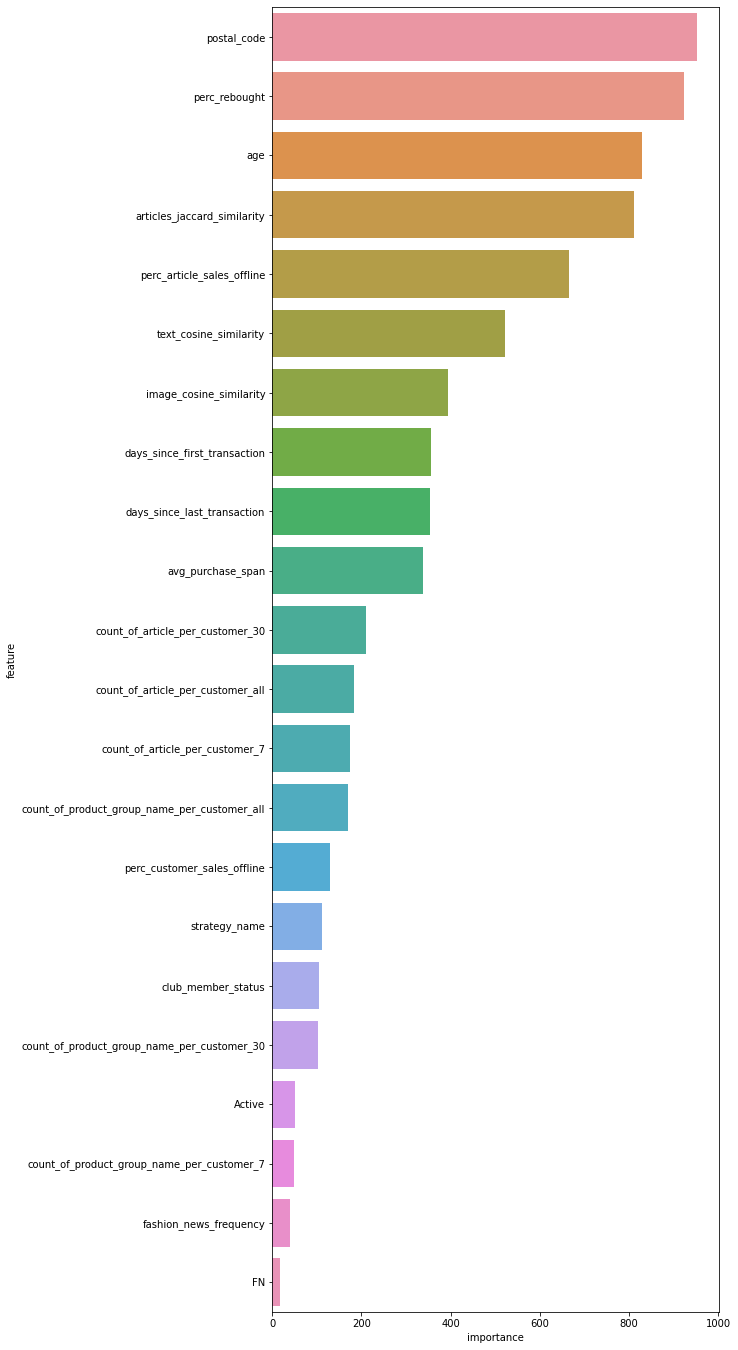

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = pd.DataFrame(
    {"feature": features, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8, 24))
sns.barplot(y="feature", x="importance", data=feat_importance)

def predict(ranker, candidates, batch_size = 10_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, features])
        probs[batch : batch + batch_size] = outputs
    candidates['prob'] = probs
    pred_lgb = val_candidates[['customer_id', 'article_id', 'prob']].sort_values(by=['customer_id', 'prob'], ascending=False).reset_index(drop=True)
    pred_lgb = pred_lgb.groupby(['customer_id']).head(12)
    return pred_lgb.groupby(['customer_id'])['article_id'].apply(list).reset_index()

### Stratified Group K Fold

In [85]:
from sklearn.model_selection import StratifiedGroupKFold

In [86]:
sgkf = StratifiedGroupKFold(n_splits=4)

In [87]:
for i, (train_idxs, val_idxs) in enumerate(sgkf.split(candidates.index, candidates.label, candidates.customer_id)):
    print(i)
    # train
    train_group = candidates.loc[train_idxs, :][['customer_id', 'article_id']]
    train_group = train_group.groupby(['customer_id']).size().values
    
    train_set = lgb.Dataset(
        data=candidates.loc[train_idxs, :][features],
        label=candidates.loc[train_idxs, :]["label"],
        group=train_group,
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )
    
    # val
    val_group = candidates.loc[val_idxs, :][['customer_id', 'article_id']]
    val_group = val_group.groupby(['customer_id']).size().values
    
    val_set = lgb.Dataset(
        data=candidates.loc[val_idxs, :][features],
        label=candidates.loc[val_idxs, :]["label"],
        group=val_group,
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )
    
    ranker = lgb.train(
        params,
        train_set,
        valid_sets=[train_set, val_set],
        valid_names=['train', 'valid'],
        num_boost_round=30,
    )

0


/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	train's map@12: 0.998845	valid's map@12: 0.998492
[2]	train's map@12: 0.99928	valid's map@12: 0.998895
[3]	train's map@12: 0.99958	valid's map@12: 0.999179
[4]	train's map@12: 0.999642	valid's map@12: 0.999228
[5]	train's map@12: 0.999664	valid's map@12: 0.999276
[6]	train's map@12: 0.999688	valid's map@12: 0.99926
[7]	train's map@12: 0.999737	valid's map@12: 0.999248
[8]	train's map@12: 0.999775	valid's map@12: 0.999272
[9]	train's map@12: 0.999788	valid's map@12: 0.999274
[10]	train's map@12: 0.999795	valid's map@12: 0.999308
[11]	train's map@12: 0.999811	valid's map@12: 0.999248
[12]	train's map@12: 0.999857	valid's map@12: 0.999267
[13]	train's map@12: 0.999865	valid's map@12: 0.999258
[14]	train's map@12: 0.99986	valid's map@12: 0.999338
[15]	train's map@12: 0.999886	valid's map@12: 0.999335
[16]	train's map@12: 0.999886	valid's map@12: 0.99934
[17]	train's map@12: 0.999883	valid's map@12: 0.999342
[18]	train's map@12: 0.999885	valid's map@12: 0.999358
[19]	train's map@12: 0.9

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	train's map@12: 0.998873	valid's map@12: 0.998525
[2]	train's map@12: 0.999397	valid's map@12: 0.998854
[3]	train's map@12: 0.999527	valid's map@12: 0.998925
[4]	train's map@12: 0.999646	valid's map@12: 0.998993
[5]	train's map@12: 0.999729	valid's map@12: 0.998995
[6]	train's map@12: 0.999765	valid's map@12: 0.998996
[7]	train's map@12: 0.999794	valid's map@12: 0.998982
[8]	train's map@12: 0.999808	valid's map@12: 0.99898
[9]	train's map@12: 0.999816	valid's map@12: 0.998993
[10]	train's map@12: 0.999825	valid's map@12: 0.998998
[11]	train's map@12: 0.999848	valid's map@12: 0.999025
[12]	train's map@12: 0.999856	valid's map@12: 0.999025
[13]	train's map@12: 0.999859	valid's map@12: 0.999038
[14]	train's map@12: 0.99986	valid's map@12: 0.999052
[15]	train's map@12: 0.999857	valid's map@12: 0.999037
[16]	train's map@12: 0.99986	valid's map@12: 0.999036
[17]	train's map@12: 0.999857	valid's map@12: 0.999051
[18]	train's map@12: 0.999857	valid's map@12: 0.999054
[19]	train's map@12: 0

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	train's map@12: 0.998744	valid's map@12: 0.99845
[2]	train's map@12: 0.999452	valid's map@12: 0.998874
[3]	train's map@12: 0.999559	valid's map@12: 0.999003
[4]	train's map@12: 0.999657	valid's map@12: 0.99912
[5]	train's map@12: 0.999699	valid's map@12: 0.999099
[6]	train's map@12: 0.999712	valid's map@12: 0.999114
[7]	train's map@12: 0.99972	valid's map@12: 0.99916
[8]	train's map@12: 0.99976	valid's map@12: 0.999166
[9]	train's map@12: 0.999756	valid's map@12: 0.999153
[10]	train's map@12: 0.999786	valid's map@12: 0.999138
[11]	train's map@12: 0.999818	valid's map@12: 0.999227
[12]	train's map@12: 0.999837	valid's map@12: 0.999221
[13]	train's map@12: 0.999844	valid's map@12: 0.999233
[14]	train's map@12: 0.999851	valid's map@12: 0.999217
[15]	train's map@12: 0.999861	valid's map@12: 0.999207
[16]	train's map@12: 0.999882	valid's map@12: 0.999214
[17]	train's map@12: 0.99987	valid's map@12: 0.999218
[18]	train's map@12: 0.999891	valid's map@12: 0.999218
[19]	train's map@12: 0.99

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	train's map@12: 0.998702	valid's map@12: 0.998429
[2]	train's map@12: 0.999386	valid's map@12: 0.998762
[3]	train's map@12: 0.99953	valid's map@12: 0.99896
[4]	train's map@12: 0.999599	valid's map@12: 0.998992
[5]	train's map@12: 0.999669	valid's map@12: 0.99905
[6]	train's map@12: 0.999695	valid's map@12: 0.99914
[7]	train's map@12: 0.999695	valid's map@12: 0.999083
[8]	train's map@12: 0.999729	valid's map@12: 0.999096
[9]	train's map@12: 0.999747	valid's map@12: 0.999133
[10]	train's map@12: 0.999764	valid's map@12: 0.999154
[11]	train's map@12: 0.999784	valid's map@12: 0.999143
[12]	train's map@12: 0.999796	valid's map@12: 0.999145
[13]	train's map@12: 0.999824	valid's map@12: 0.999137
[14]	train's map@12: 0.999838	valid's map@12: 0.999133
[15]	train's map@12: 0.999846	valid's map@12: 0.99915
[16]	train's map@12: 0.999855	valid's map@12: 0.999185
[17]	train's map@12: 0.999856	valid's map@12: 0.999187
[18]	train's map@12: 0.999855	valid's map@12: 0.999196
[19]	train's map@12: 0.9

In [88]:
ranker

In [110]:
probs = np.zeros(val_candidates.shape[0])

In [111]:
probs

array([0., 0., 0., ..., 0., 0., 0.])

In [112]:
for batch in range(0, val_candidates.shape[0], 5_000_000):
    outputs = ranker.predict(val_candidates.loc[batch : batch + 5_000_000 - 1, features])
    probs[batch : batch + 5_000_000] = outputs

In [113]:
val_candidates["prob"] = probs

/var/folders/dl/55k0mmrx765_h9n3c5rmqz8c0000gn/T/ipykernel_5583/3238427657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_candidates["prob"] = probs


In [114]:
pred_lgb = val_candidates[['customer_id', 'article_id', 'prob']].sort_values(by=['customer_id', 'prob'], ascending=False).reset_index(drop=True)

In [115]:
pred_lgb

,customer_id,article_id,prob
0,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0554479001,-1.2214
1,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0904571001,-1.2214
2,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0869331006,-1.2214
3,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0792469001,-1.2214
4,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0902528006,-1.2214
...,...,...,...
669381,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0579541086,-1.2215
669382,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0863565004,-1.2215
669383,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0720504008,-1.2215
669384,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0907951001,-1.2215


In [116]:
pred_lgb.prob.describe()

count   669386.0000
mean        -1.2203
std          0.0497
min         -1.3059
25%         -1.2225
50%         -1.2215
75%         -1.2215
max          1.2125
Name: prob, dtype: float64

In [117]:
pred_lgb = pred_lgb.groupby(['customer_id']).head(12)

pred_lgb.loc[:, ['customer_id', 'article_id']] = pred_lgb.loc[:, ['customer_id', 'article_id']].astype(str)

In [118]:
pred_lgb.customer_id.nunique()

2000

In [119]:
pred_lgb.head(13)

,customer_id,article_id,prob
0,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0554479001,-1.2214
1,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0904571001,-1.2214
2,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0869331006,-1.2214
3,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0792469001,-1.2214
4,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0902528006,-1.2214
...,...,...,...
8,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0832481002,-1.2214
9,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0688728023,-1.2214
10,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0158340001,-1.2214
11,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0706016015,-1.2214


In [120]:
pred_lgb.groupby(['customer_id'])['article_id'].apply(list).reset_index()

,customer_id,article_id
0,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,"[0554479001, 0904571001, 0869331006, 079246900..."
1,000df6cf5f902e6bb2a45b94d96c82c62324fe04bea329...,"[0907951001, 0867994001, 0831269009, 090402600..."
2,0065848cb03f4147bfe8f8c4c5ae3fce496ad9c3389fc3...,"[0832473001, 0861514001, 0783346020, 076346900..."
3,009ce0498e522ba4d20a80b7aaecd8567b15b52eb78c0c...,"[0907951001, 0867994001, 0831269009, 090402600..."
4,00cd746a1260bc81b14b21a23e29fd520b37cd32d92b09...,"[0554479001, 0904571001, 0869331006, 079246900..."
...,...,...
1995,ff4a33dfcf512d6beb354aef28c2d8a2b4cc690db15817...,"[0554479001, 0904571001, 0869331006, 079246900..."
1996,ff7dceb4dbc99277091f7adaa81932a7ea237b7e108a69...,"[0554479001, 0904571001, 0869331006, 079246900..."
1997,ff993b649c572f16988976c8706f64ed23daa0a1b0e246...,"[0907951001, 0904026002, 0554479001, 090457100..."
1998,ffd11fc7ac9aa1e2da89d1c3137a4218c15a51eaa74ce1...,"[0907951001, 0867994001, 0831269009, 090402600..."


### Stratified Group Split

##### groups

In [97]:
train_group = train_candidates[['customer_id', 'article_id']]

In [98]:
train_group = train_group.groupby(['customer_id']).size().values

In [99]:
val_group = val_candidates[['customer_id', 'article_id']]

In [100]:
val_group = val_group.groupby(['customer_id']).size().values

##### datasets

In [101]:
train_set = lgb.Dataset(
        data=train_candidates[features],
        label=train_candidates["label"],
        group=train_group,
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )

In [102]:
val_set = lgb.Dataset(
        data=val_candidates[features],
        label=val_candidates["label"],
        group=val_group,
        feature_name=features,
        categorical_feature=cat_features,
        params=params,
    )

del candidates
gc.collect()

In [103]:
ranker = lgb.train(
        params,
        train_set,
        valid_sets=[val_set],
        num_boost_round=30,
    )

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's map@12: 0.990436
[2]	valid_0's map@12: 0.993439
[3]	valid_0's map@12: 0.994622
[4]	valid_0's map@12: 0.995803
[5]	valid_0's map@12: 0.996042
[6]	valid_0's map@12: 0.996086
[7]	valid_0's map@12: 0.996132
[8]	valid_0's map@12: 0.995635
[9]	valid_0's map@12: 0.995471
[10]	valid_0's map@12: 0.995491
[11]	valid_0's map@12: 0.995782
[12]	valid_0's map@12: 0.995719
[13]	valid_0's map@12: 0.995764
[14]	valid_0's map@12: 0.995777
[15]	valid_0's map@12: 0.995519
[16]	valid_0's map@12: 0.995648
[17]	valid_0's map@12: 0.995654
[18]	valid_0's map@12: 0.995604
[19]	valid_0's map@12: 0.995582
[20]	valid_0's map@12: 0.995582
[21]	valid_0's map@12: 0.99561
[22]	valid_0's map@12: 0.995619
[23]	valid_0's map@12: 0.995656
[24]	valid_0's map@12: 0.995671
[25]	valid_0's map@12: 0.995648
[26]	valid_0's map@12: 0.995648
[27]	valid_0's map@12: 0.995898
[28]	valid_0's map@12: 0.996186
[29]	valid_0's map@12: 0.996186
[30]	valid_0's map@12: 0.996186


In [104]:
ranker

In [105]:
feat_importance = pd.DataFrame(
    {"feature": features, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mmadej/Desktop/Projects/gid-ml-framework/.venv/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='importance', ylabel='feature'>

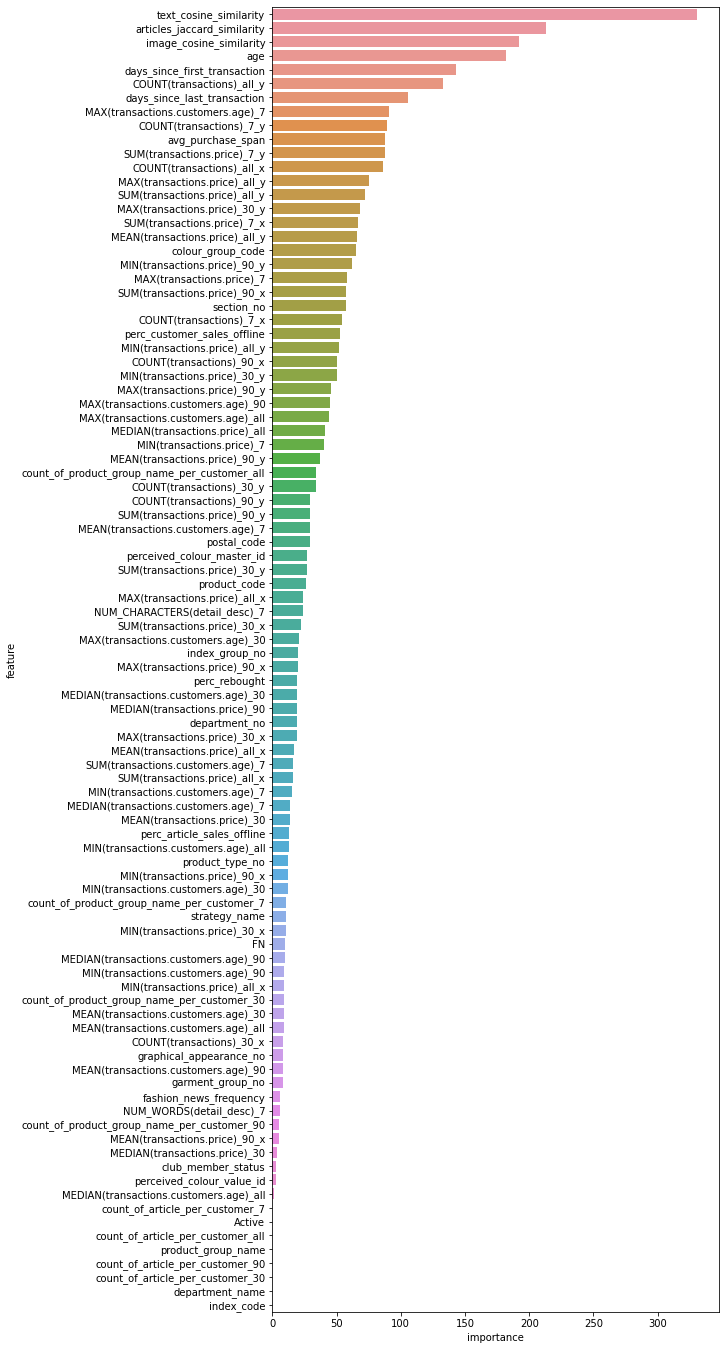

In [107]:
plt.figure(figsize=(8, 24))
sns.barplot(y="feature", x="importance", data=feat_importance)

In [108]:
def predict(ranker, candidates, batch_size = 1_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, features])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id', 'article_id', 'prob']]
    pred_lgb = pred_lgb.sort_values(by=['customer_id', 'prob'], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id': 'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].apply(list).reset_index()
    return pred_lgb

In [109]:
pred = predict(ranker, val_candidates)

ValueError: could not broadcast input array from shape (205582,) into shape (669386,)

In [111]:
pred

,customer_id,prediction
0,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,[]
1,0006a10483f4b1d47dd0c640429a1c059f224c3a87464c...,[]
2,000df6cf5f902e6bb2a45b94d96c82c62324fe04bea329...,[]
3,00208fb274f1f5a739702ce60ed1bf6106910fa990b4bc...,[]
4,003292a63d9ca49d46dd66ffbbd6cca6e02f50f6b5f488...,[]
...,...,...
9995,ffe98d88192feecce39e53d5f0cfa5343e3a1b51677e1d...,[]
9996,fff187d1386edced8ef49b1df0155241943c9c4cc7abbf...,[]
9997,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,[]
9998,fff69e3ab1bd701315881c7706c38d5cbcda1f4e0cf213...,[]


In [110]:
probs = np.zeros(val_candidates.shape[0])

In [111]:
probs

array([0., 0., 0., ..., 0., 0., 0.])

In [112]:
for batch in range(0, val_candidates.shape[0], 5_000_000):
    outputs = ranker.predict(val_candidates.loc[batch : batch + 5_000_000 - 1, features])
    probs[batch : batch + 5_000_000] = outputs

In [113]:
val_candidates["prob"] = probs

/var/folders/dl/55k0mmrx765_h9n3c5rmqz8c0000gn/T/ipykernel_5583/3238427657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_candidates["prob"] = probs


In [114]:
pred_lgb = val_candidates[['customer_id', 'article_id', 'prob']].sort_values(by=['customer_id', 'prob'], ascending=False).reset_index(drop=True)

In [115]:
pred_lgb

,customer_id,article_id,prob
0,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0554479001,-1.2214
1,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0904571001,-1.2214
2,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0869331006,-1.2214
3,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0792469001,-1.2214
4,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0902528006,-1.2214
...,...,...,...
669381,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0579541086,-1.2215
669382,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0863565004,-1.2215
669383,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0720504008,-1.2215
669384,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,0907951001,-1.2215


In [116]:
pred_lgb.prob.describe()

count   669386.0000
mean        -1.2203
std          0.0497
min         -1.3059
25%         -1.2225
50%         -1.2215
75%         -1.2215
max          1.2125
Name: prob, dtype: float64

In [117]:
pred_lgb = pred_lgb.groupby(['customer_id']).head(12)

pred_lgb.loc[:, ['customer_id', 'article_id']] = pred_lgb.loc[:, ['customer_id', 'article_id']].astype(str)

In [118]:
pred_lgb.customer_id.nunique()

2000

In [119]:
pred_lgb.head(13)

,customer_id,article_id,prob
0,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0554479001,-1.2214
1,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0904571001,-1.2214
2,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0869331006,-1.2214
3,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0792469001,-1.2214
4,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0902528006,-1.2214
...,...,...,...
8,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0832481002,-1.2214
9,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0688728023,-1.2214
10,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0158340001,-1.2214
11,fff62d5b7df1ffc31c733ccf4b59af21d645e2b2d11256...,0706016015,-1.2214


In [120]:
pred_lgb.groupby(['customer_id'])['article_id'].apply(list).reset_index()

,customer_id,article_id
0,0003e56a4332b2503e34640be92031ad48f1280ee6e3a7...,"[0554479001, 0904571001, 0869331006, 079246900..."
1,000df6cf5f902e6bb2a45b94d96c82c62324fe04bea329...,"[0907951001, 0867994001, 0831269009, 090402600..."
2,0065848cb03f4147bfe8f8c4c5ae3fce496ad9c3389fc3...,"[0832473001, 0861514001, 0783346020, 076346900..."
3,009ce0498e522ba4d20a80b7aaecd8567b15b52eb78c0c...,"[0907951001, 0867994001, 0831269009, 090402600..."
4,00cd746a1260bc81b14b21a23e29fd520b37cd32d92b09...,"[0554479001, 0904571001, 0869331006, 079246900..."
...,...,...
1995,ff4a33dfcf512d6beb354aef28c2d8a2b4cc690db15817...,"[0554479001, 0904571001, 0869331006, 079246900..."
1996,ff7dceb4dbc99277091f7adaa81932a7ea237b7e108a69...,"[0554479001, 0904571001, 0869331006, 079246900..."
1997,ff993b649c572f16988976c8706f64ed23daa0a1b0e246...,"[0907951001, 0904026002, 0554479001, 090457100..."
1998,ffd11fc7ac9aa1e2da89d1c3137a4218c15a51eaa74ce1...,"[0907951001, 0867994001, 0831269009, 090402600..."
